In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
all_cards = pd.read_csv('cleaned_datasets/allsets_cleaned.csv', index_col=0)
all_cards.head()

,name,colors,manaValue,manaCost,power,toughness,loyalty,text,rarity,keywords,supertypes,types,subtypes
0,Aerial Modification,W,5.0,{4}{W},NaN,NaN,NaN,Enchant creature or Vehicle\nAs long as enchan...,uncommon,Enchant,NaN,Enchantment,Aura
1,Aeronaut Admiral,W,4.0,{3}{W},3.0,1.0,NaN,Flying\nVehicles you control have flying.,uncommon,Flying,NaN,Creature,"Human, Pilot"
2,Aether Inspector,W,4.0,{3}{W},2.0,3.0,NaN,Vigilance\nWhen Aether Inspector enters the ba...,common,Vigilance,NaN,Creature,"Dwarf, Artificer"
3,Aethergeode Miner,W,2.0,{1}{W},3.0,1.0,NaN,"Whenever Aethergeode Miner attacks, you get {E...",rare,NaN,NaN,Creature,"Dwarf, Scout"
4,Airdrop Aeronauts,W,5.0,{3}{W}{W},4.0,3.0,NaN,Flying\nRevolt — When Airdrop Aeronauts enters...,uncommon,"Flying, Revolt",NaN,Creature,"Dwarf, Scout"


In [3]:
all_cards.types.unique()

array(['Enchantment', 'Creature', 'Instant', 'Sorcery', 'Planeswalker',
       'Artifact, Creature', 'Artifact', 'Land', 'Artifact, Land',
       'Enchantment, Creature'], dtype=object)

In [4]:
all_cards.types.value_counts()

Creature                 3533
Instant                   881
Sorcery                   804
Enchantment               599
Artifact                  412
Land                      334
Artifact, Creature        197
Planeswalker              168
Enchantment, Creature      94
Artifact, Land              1
Name: types, dtype: int64

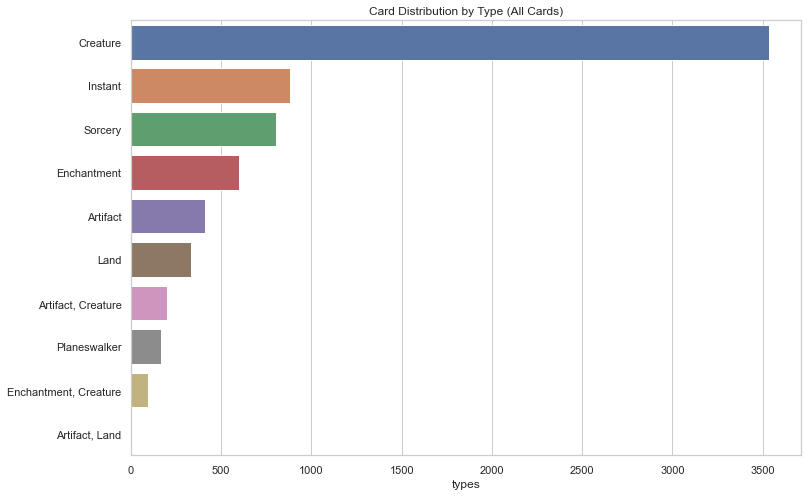

In [5]:
sns.set_theme(style='whitegrid', rc = {'figure.figsize':(12,8)})
ax = sns.barplot(x = all_cards.types.value_counts(), y = all_cards.types.value_counts().index, 
                 orient = 'h').set(title = 'Card Distribution by Type (All Cards)')

We can easily see in the above graph that the Creature Card type is by far the largest group in our dataset, and for that reason, plus the fact that creatures come with built-in numerical values to consider (power and toughness), this will be the focus of the investigation.  If we were to include other card types, we would likely have to go down the rabbit hole of Natural Language Processing and/or large amounts of RegEx expressions, which will unfortunately be beyond the scope of this analysis.


Additionally, the number & variety of multi-colored cards would make the analysis at this point overly complicated, so for most of our visualizations here, I'm going to drop multi-colored cards as well.

In [6]:
all_cards['numColors'] = all_cards.colors.str.split(', ').str.len()

In [7]:
mono_colored = all_cards.query('numColors == 1')

We've dropped a little over 10% of the dataset, but the trade-off in simplifying things is likely worth it.

In [8]:
print(all_cards.shape)
print(mono_colored.shape)

(7023, 14)
(6118, 14)


And since a lot of our analysis here is going to be taking Colors into account and Lands, by the game rules, do not themselves have colors (and are not spells), we're going to drop all the lands from our dataset as well.

In [9]:
mono_colored = mono_colored.loc[~mono_colored.types.str.contains('Land')].copy()

In [10]:
mono_colored.types.unique()

array(['Enchantment', 'Creature', 'Instant', 'Sorcery',
       'Artifact, Creature', 'Artifact', 'Planeswalker',
       'Enchantment, Creature'], dtype=object)

In [11]:
mono_colored.shape

(5783, 14)

In [12]:
# Setting a palette to use in Seaborn that co-ordinates with our colors. Going for a yellowish hue to represent White

palette = {"W":"tab:olive",
           "U":"tab:blue", 
           "B":"black",
           "R":"tab:red",
           "G":"tab:green",
           "C":"tab:gray"}

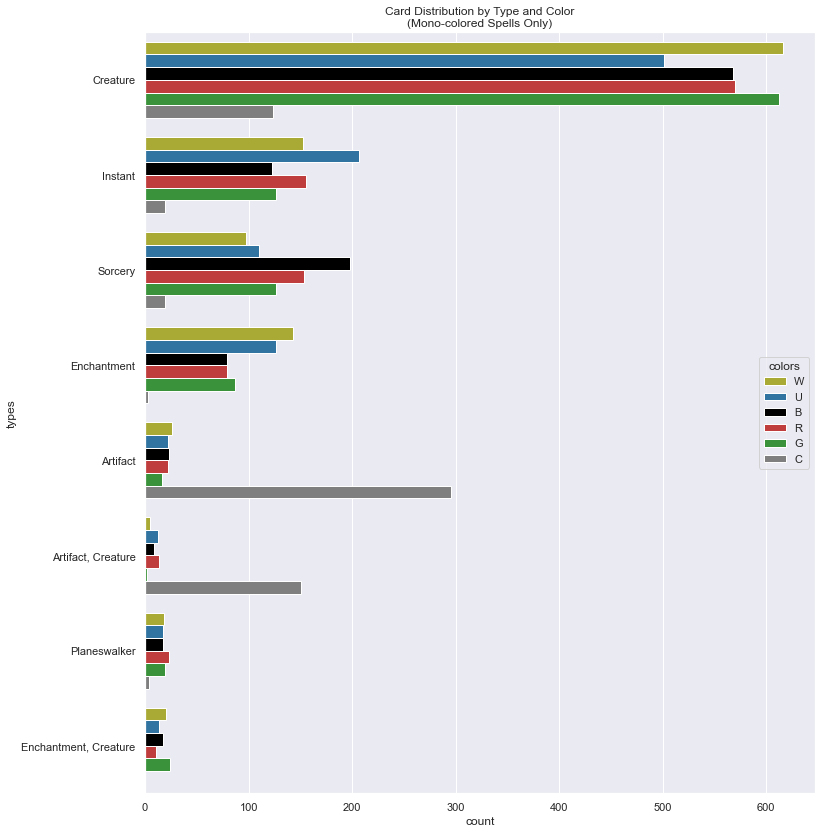

In [13]:
sns.set_theme(rc = {'figure.figsize':(12,14)})
ax = sns.countplot(data = mono_colored, y='types', hue = 'colors', order = mono_colored.types.value_counts().index,
                   palette=palette).set(title = 'Card Distribution by Type and Color\n(Mono-colored Spells Only)')

The above chart shows us a couple interesting things.  First, we see that Blue has a significantly smaller number of creatures represented as compared to the other four colors (which makes sense, as the they also have more non-creature spells (specifically instants and enchantments) than most others.  We can also note that Artifacts, and specifically Artifact Creatures skew almost entirely Colorless.


Below, we look at the overall card distribution by mana value, and see more or less what we would expect to see:  most cards fall in the 2-4 mana value range, with a few outliers that are very expensive.

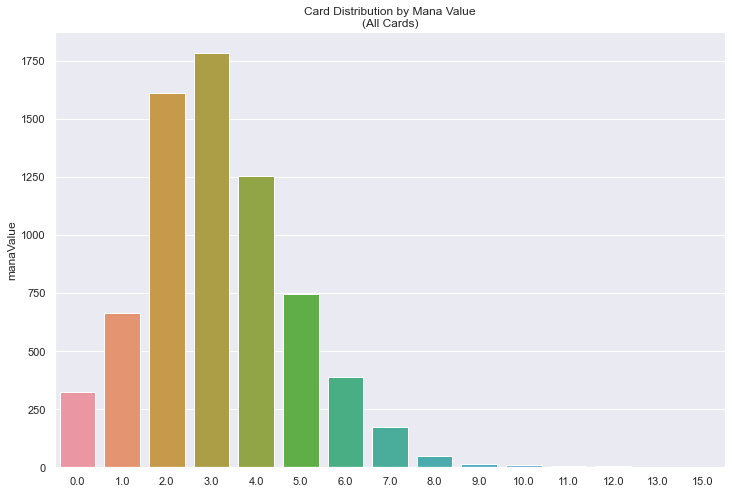

In [14]:
sns.set_theme(rc = {'figure.figsize':(12,8)})
ax = sns.barplot(y = all_cards.manaValue.value_counts(), x = all_cards.manaValue.value_counts().index, 
                 orient = 'v').set(title = 'Card Distribution by Mana Value\n(All Cards)')

Taking a look at our mono-colored dataset, we can confirm that there is a roughly even distribution of cards for the five primary colors at each mana value  from 1 through 7 (inclusive).

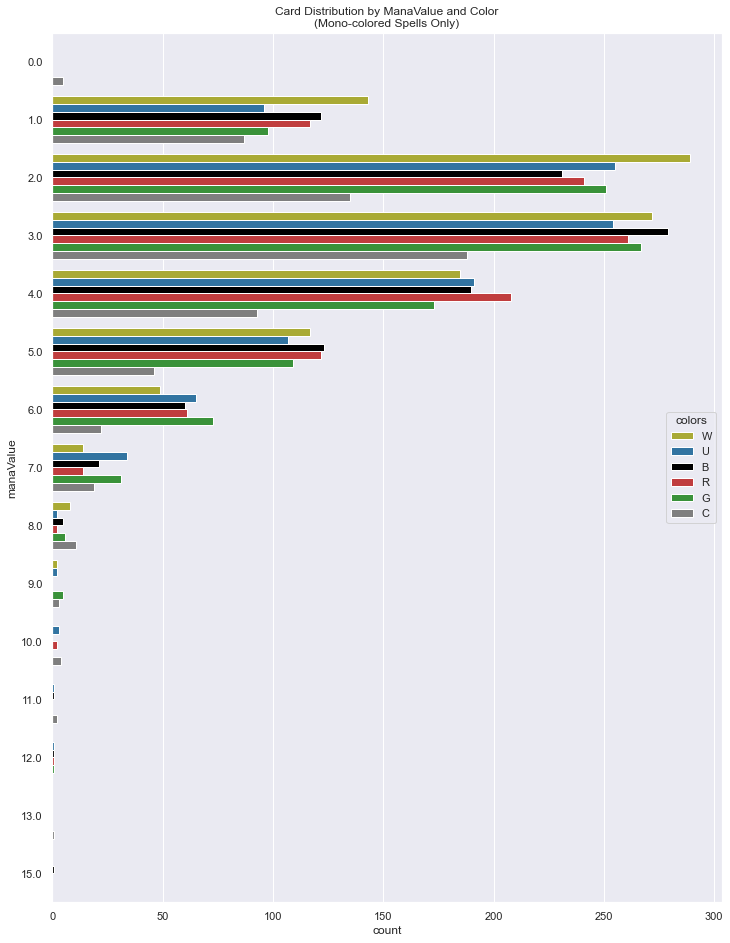

In [16]:
sns.set_theme(rc = {'figure.figsize':(12,16)})
ax = sns.countplot(data = mono_colored, y='manaValue', hue = 'colors',
                   palette=palette).set(title = 'Card Distribution by ManaValue and Color\n(Mono-colored Spells Only)')

Since I'm eventually going to focus on analyzing just the creature cards, I extract them here. We can see that we're left with just less than 50% of the `all_cards` dataframe.

In [17]:
creatures = mono_colored.loc[all_cards.types.str.contains('Creature')].copy()

In [18]:
print(all_cards.shape)
print(creatures.shape)

(7023, 14)
(3271, 14)


And looking at only the creatures, we see a distribution that pretty closely maps to the distribution of all cards by color.  Again, this is pretty much what we expect to see.

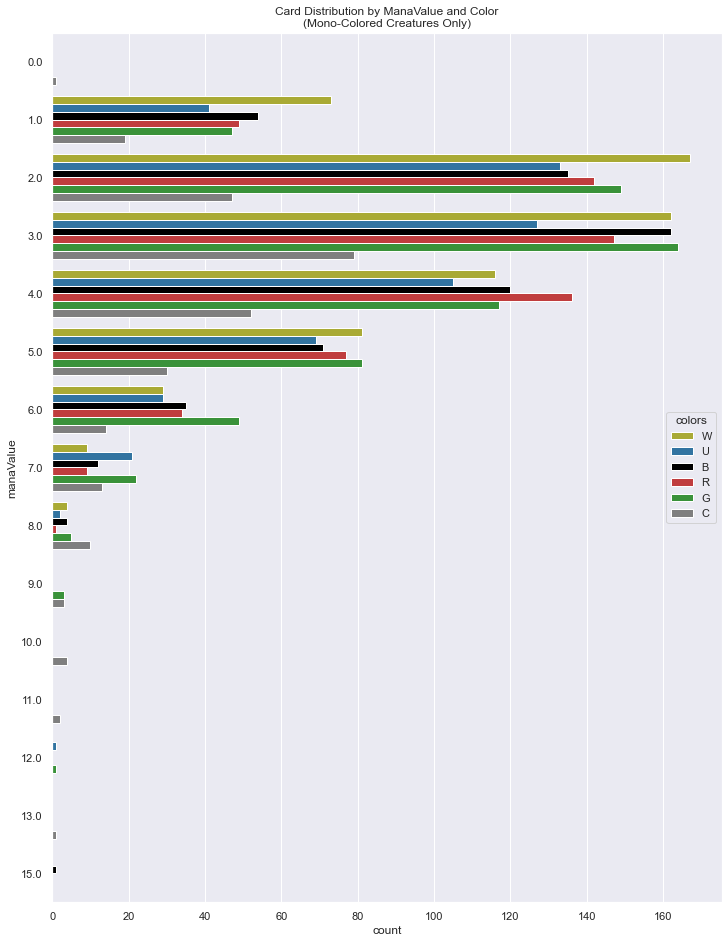

In [19]:
sns.set_theme(rc = {'figure.figsize':(12,16)})
ax = sns.countplot(data = creatures, y='manaValue', hue = 'colors',
                   palette=palette).set(title = 'Card Distribution by ManaValue and Color\n(Mono-Colored Creatures Only)')

Below, we can see the distribution by rarity for all cards as well as creatures.  As expected, mythics have a much smaller representation in the dataset, so if rarity becomes an object of investigation, we will likely have to consider over/undersampling to get balanced datasets.

[Text(0.5, 1.0, 'Card Distribution by Rarity\n(Mono-colored Creatures Only)')]

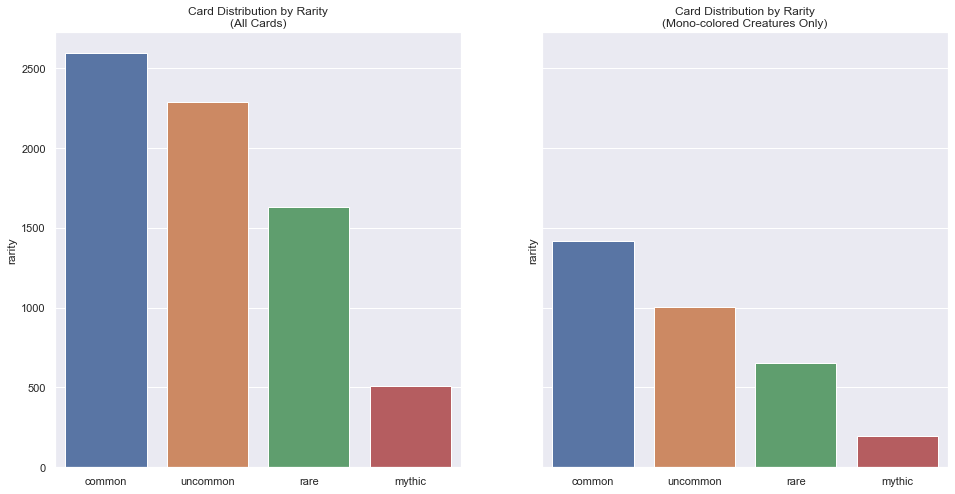

In [20]:
sns.set_theme(rc = {'figure.figsize':(16,8)})
fig, ax = plt.subplots(1,2, sharey=True)

sns.barplot(y = all_cards.rarity.value_counts(), x = all_cards.rarity.value_counts().index, 
            orient = 'v', ax=ax[0]).set(title = 'Card Distribution by Rarity\n(All Cards)')
sns.barplot(y = creatures.rarity.value_counts(), x = creatures.rarity.value_counts().index, 
            orient = 'v', ax=ax[1]).set(title = 'Card Distribution by Rarity\n(Mono-colored Creatures Only)')

Here, I'm making a new dataframe with separate columns for each keyword, so we can easily graph the occurence of individual keywords.

In [21]:
creatures_keywords = pd.concat([creatures, creatures.keywords.str.get_dummies(sep=", ")], axis=1)

In [22]:
creatures_keywords.columns

Index(['name', 'colors', 'manaValue', 'manaCost', 'power', 'toughness',
       'loyalty', 'text', 'rarity', 'keywords', 'supertypes', 'types',
       'subtypes', 'numColors', 'Adamant', 'Adapt', 'Afflict', 'Afterlife',
       'Alliance', 'Amass', 'Ascend', 'Blitz', 'Boast', 'Changeling',
       'Channel', 'Cohort', 'Connive', 'Constellation', 'Converge', 'Convoke',
       'Coven', 'Cycling', 'Daybound', 'Deathtouch', 'Defender', 'Delirium',
       'Devoid', 'Disturb', 'Double strike', 'Embalm', 'Emerge', 'Enchant',
       'Enrage', 'Equip', 'Escape', 'Eternalize', 'Exert', 'Exploit',
       'Explore', 'Fabricate', 'Fight', 'First strike', 'Flash', 'Flying',
       'Foretell', 'Haste', 'Hexproof', 'Hexproof from', 'Improvise',
       'Indestructible', 'Ingest', 'Investigate', 'Kicker', 'Landfall',
       'Learn', 'Lifelink', 'Madness', 'Magecraft', 'Meld', 'Menace', 'Mentor',
       'Mill', 'Mutate', 'Nightbound', 'Ninjutsu', 'Pack tactics',
       'Proliferate', 'Protection', 'Prowess'

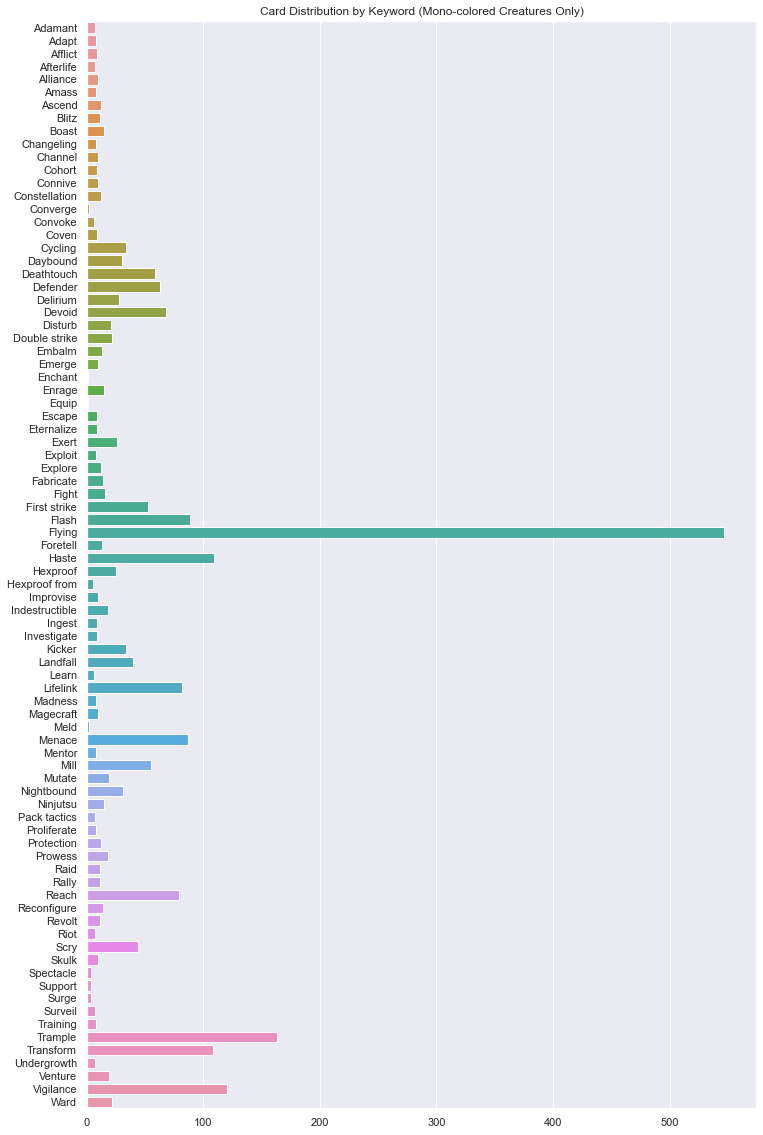

In [23]:
sns.set_theme(rc = {'figure.figsize':(12,20)})
ax = sns.barplot(x = creatures_keywords.loc[:, 'Adamant':].sum(), y = creatures_keywords.loc[:, 'Adamant':].sum().index, 
                 orient = 'h').set(title = 'Card Distribution by Keyword (Mono-colored Creatures Only)')

In [24]:
creatures_keywords.loc[:, 'Adamant':].sum().nlargest(n=10)

Flying       547
Trample      163
Vigilance    120
Haste        109
Transform    108
Flash         89
Menace        87
Lifelink      82
Reach         79
Devoid        68
dtype: int64

In [25]:
creatures.keywords.fillna('', inplace=True)

In [38]:
creatures[creatures.keywords.str.contains('Flying')]

,name,colors,manaValue,manaCost,power,toughness,loyalty,text,rarity,keywords,supertypes,types,subtypes,numColors
1,Aeronaut Admiral,W,4.0,{3}{W},3.0,1.0,NaN,Flying\nVehicles you control have flying.,uncommon,Flying,NaN,Creature,"Human, Pilot",1
4,Airdrop Aeronauts,W,5.0,{3}{W}{W},4.0,3.0,NaN,Flying\nRevolt — When Airdrop Aeronauts enters...,uncommon,"Flying, Revolt",NaN,Creature,"Dwarf, Scout",1
13,Dawnfeather Eagle,W,5.0,{4}{W},3.0,3.0,NaN,Flying\nWhen Dawnfeather Eagle enters the batt...,common,Flying,NaN,Creature,Bird,1
17,Exquisite Archangel,W,7.0,{5}{W}{W},5.0,5.0,NaN,"Flying\nIf you would lose the game, instead ex...",mythic,Flying,NaN,Creature,Angel,1
19,Ghirapur Osprey,W,3.0,{2}{W},2.0,2.0,NaN,Flying,common,Flying,NaN,Creature,Bird,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6862,Nimana Skydancer,B,3.0,{2}{B},2.0,1.0,NaN,Flash\nFlying\nWhen Nimana Skydancer enters th...,common,"Flash, Flying, Mill",NaN,Creature,"Human, Rogue",1
6867,Scion of the Swarm,B,5.0,{3}{B}{B},3.0,3.0,NaN,"Flying\nWhenever you gain life, put a +1/+1 co...",uncommon,Flying,NaN,Creature,"Vampire, Cleric",1
6874,"Taborax, Hope's Demise",B,3.0,{2}{B},2.0,2.0,NaN,"Flying\nTaborax, Hope's Demise has lifelink as...",rare,Flying,Legendary,Creature,"Demon, Cleric",1
6894,Leyline Tyrant,R,4.0,{2}{R}{R},4.0,4.0,NaN,Flying\nYou don't lose unspent red mana as ste...,mythic,Flying,NaN,Creature,Dragon,1


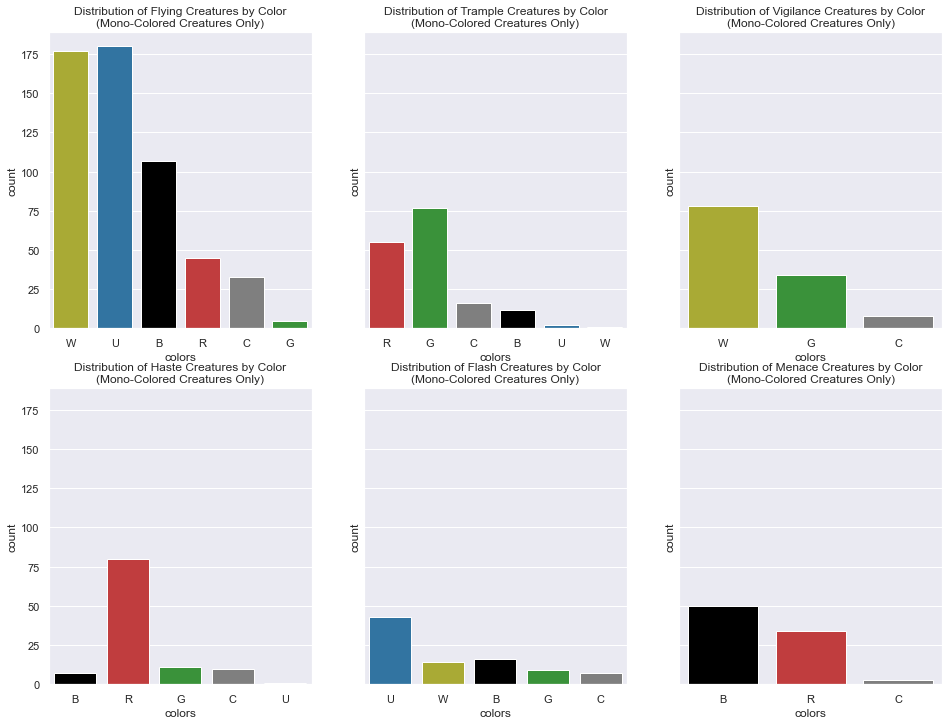

In [53]:
from math import floor
sns.set_theme(rc = {'figure.figsize':(16,12)})
fig, ax = plt.subplots(2,3, sharey=True)
to_plot = ['Flying', 'Trample', 'Vigilance', 'Haste', 'Flash', 'Menace']

for count, keyword in enumerate(to_plot):    
    sns.countplot(data = creatures[creatures.keywords.str.contains(keyword)], x='colors', palette=palette, 
                  ax=ax[floor(count/3)][count%3]).set(title = 'Distribution of '+ keyword +
                                                      ' Creatures by Color\n(Mono-Colored Creatures Only)')

plt.show()

In [32]:
def jitter_arr(arr):
    stdev = .02 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

<AxesSubplot:xlabel='power', ylabel='toughness'>

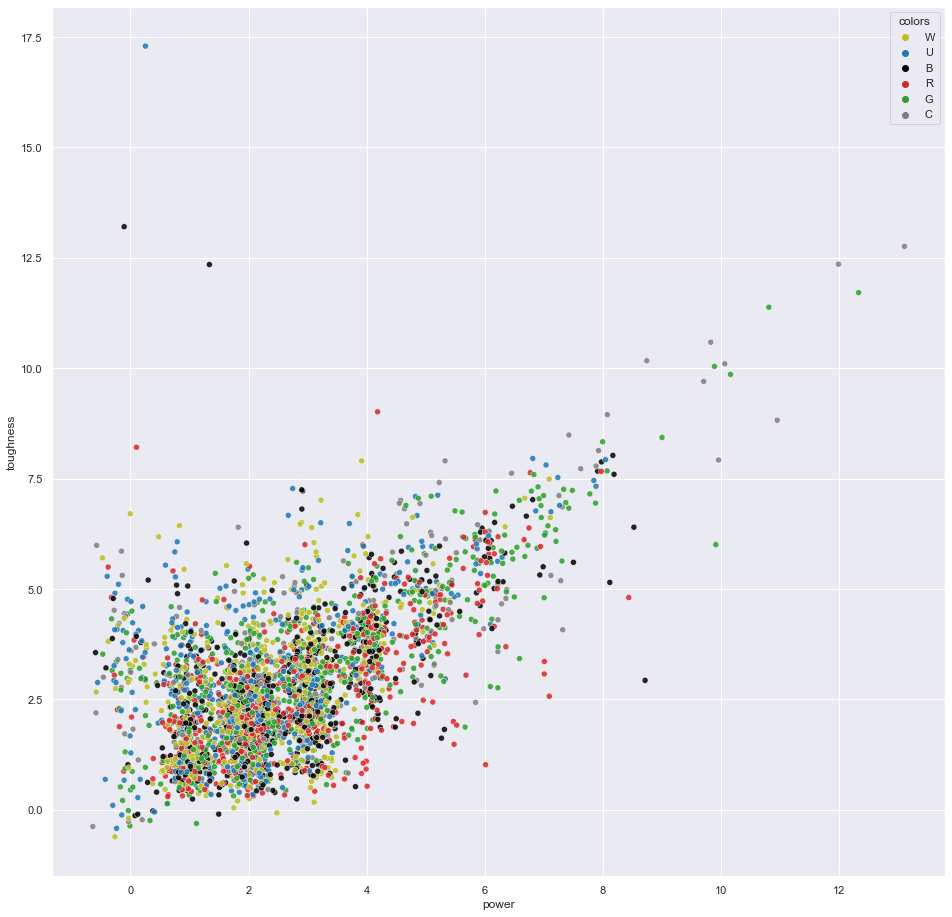

In [57]:
sns.set_theme(rc = {'figure.figsize':(16,16)})
sns.scatterplot(data = creatures, x = jitter_arr(creatures['power']), y = jitter_arr(creatures['toughness']), hue='colors',
                palette=palette, alpha=.85)

In [58]:
creatures['combined_pow_tough'] = creatures['power'] + creatures['toughness']

In [59]:
creatures.head()

,name,colors,manaValue,manaCost,power,toughness,loyalty,text,rarity,keywords,supertypes,types,subtypes,numColors,combined_pow_tough
1,Aeronaut Admiral,W,4.0,{3}{W},3.0,1.0,NaN,Flying\nVehicles you control have flying.,uncommon,Flying,NaN,Creature,"Human, Pilot",1,4.0
2,Aether Inspector,W,4.0,{3}{W},2.0,3.0,NaN,Vigilance\nWhen Aether Inspector enters the ba...,common,Vigilance,NaN,Creature,"Dwarf, Artificer",1,5.0
3,Aethergeode Miner,W,2.0,{1}{W},3.0,1.0,NaN,"Whenever Aethergeode Miner attacks, you get {E...",rare,,NaN,Creature,"Dwarf, Scout",1,4.0
4,Airdrop Aeronauts,W,5.0,{3}{W}{W},4.0,3.0,NaN,Flying\nRevolt — When Airdrop Aeronauts enters...,uncommon,"Flying, Revolt",NaN,Creature,"Dwarf, Scout",1,7.0
6,Audacious Infiltrator,W,2.0,{1}{W},3.0,1.0,NaN,Audacious Infiltrator can't be blocked by arti...,common,,NaN,Creature,"Dwarf, Rogue",1,4.0


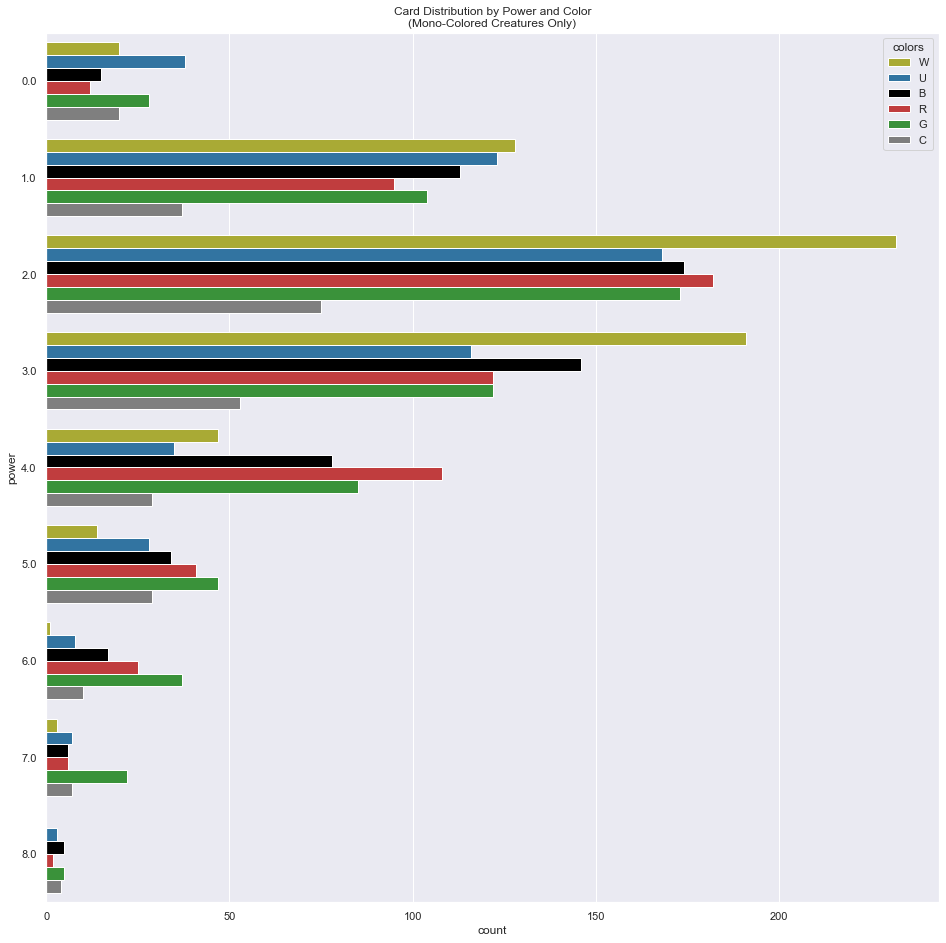

In [72]:
sns.set_theme(rc = {'figure.figsize':(16,16)})
ax = sns.countplot(data = creatures.query('power < 9'), y='power', hue = 'colors', 
                   palette=palette).set(title = 'Card Distribution by Power and Color\n(Mono-Colored Creatures Only)')

In [ ]:
sns.set_theme(rc = {'figure.figsize':(16,16)})
ax = sns.countplot(data = creatures, y='toughness', hue = 'colors',
                   palette=palette).set(title = 'Card Distribution by Toughness and Color\n(Mono-Colored Creatures Only)')

In [ ]:
sns.set_theme(rc = {'figure.figsize':(16,16)})
ax = sns.countplot(data = creatures, y='combined_pow_tough', hue = 'colors',
                   palette=palette).set(title = 'Card Distribution by Combined Stats and Color\n(Mono-Colored Creatures Only)')

In [ ]:
sns.scatterplot(data = creatures, x = creatures['combined_pow_tough'], y =creatures['manaValue'], 
                hue='colors', palette=palette, alpha=.25)

In [ ]:
creatures.query('manaValue > 10')

In [ ]:
fig, ax = plt.subplots(2,3, sharey=True, sharex=True)
sns.scatterplot(x=creatures[creatures.colors.eq('W')]['power'], 
                y=creatures[creatures.colors.eq('W')]['manaValue'], c=['olive'],
                ax=ax[0][0], alpha=.1).set(title = 'Distribution of Power vs ManaValue\n(White Creatures Only)')
sns.scatterplot(x=creatures[creatures.colors.eq('U')]['power'], 
                y=creatures[creatures.colors.eq('U')]['manaValue'], c=['blue'],
                ax=ax[0][1], alpha=.1).set(title = 'Distribution of Power vs ManaValue\n(Blue Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('B')]['power']), 
                y=jitter_arr(creatures[creatures.colors.eq('B')]['manaValue']), c=['black'],
                ax=ax[0][2]).set(title = 'Distribution of Power vs ManaValue\n(Black Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('R')]['power']), 
                y=jitter_arr(creatures[creatures.colors.eq('R')]['manaValue']), c=['red'],
                ax=ax[1][0]).set(title = 'Distribution of Power vs ManaValue\n(Red Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('G')]['power']), 
                y=jitter_arr(creatures[creatures.colors.eq('G')]['manaValue']), c=['green'],
                ax=ax[1][1]).set(title = 'Distribution of Power vs ManaValue\n(Green Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('C')]['power']), 
                y=jitter_arr(creatures[creatures.colors.eq('C')]['manaValue']), c=['gray'],
                ax=ax[1][2]).set(title = 'Distribution of Power vs ManaValue\n(Colorless Creatures Only)')

In [ ]:
fig, ax = plt.subplots(2,3, sharey=True, sharex=True)
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('W')]['toughness']), 
                y=jitter_arr(creatures[creatures.colors.eq('W')]['manaValue']), c=['olive'],
                ax=ax[0][0]).set(title = 'Distribution of Toughness vs ManaValue\n(White Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('U')]['toughness']), 
                y=jitter_arr(creatures[creatures.colors.eq('U')]['manaValue']), c=['blue'],
                ax=ax[0][1]).set(title = 'Distribution of Toughness vs ManaValue\n(Blue Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('B')]['toughness']), 
                y=jitter_arr(creatures[creatures.colors.eq('B')]['manaValue']), c=['black'],
                ax=ax[0][2]).set(title = 'Distribution of Toughness vs ManaValue\n(Black Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('R')]['toughness']), 
                y=jitter_arr(creatures[creatures.colors.eq('R')]['manaValue']), c=['red'],
                ax=ax[1][0]).set(title = 'Distribution of Toughness vs ManaValue\n(Red Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('G')]['toughness']), 
                y=jitter_arr(creatures[creatures.colors.eq('G')]['manaValue']), c=['green'],
                ax=ax[1][1]).set(title = 'Distribution of Toughness vs ManaValue\n(Green Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('C')]['toughness']), 
                y=jitter_arr(creatures[creatures.colors.eq('C')]['manaValue']), c=['gray'],
                ax=ax[1][2]).set(title = 'Distribution of Toughness vs ManaValue\n(Colorless Creatures Only)')

In [ ]:
fig, ax = plt.subplots(2,3, sharey=True, sharex=True)
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('W')]['combined_pow_tough']), 
                y=jitter_arr(creatures[creatures.colors.eq('W')]['manaValue']), c=['olive'],
                ax=ax[0][0]).set(title = 'Distribution of Combined Stats vs ManaValue\n(White Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('U')]['combined_pow_tough']), 
                y=jitter_arr(creatures[creatures.colors.eq('U')]['manaValue']), c=['blue'],
                ax=ax[0][1]).set(title = 'Distribution of Combined Stats vs ManaValue\n(Blue Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('B')]['combined_pow_tough']), 
                y=jitter_arr(creatures[creatures.colors.eq('B')]['manaValue']), c=['black'],
                ax=ax[0][2]).set(title = 'Distribution of Combined Stats vs ManaValue\n(Black Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('R')]['combined_pow_tough']), 
                y=jitter_arr(creatures[creatures.colors.eq('R')]['manaValue']), c=['red'],
                ax=ax[1][0]).set(title = 'Distribution of Combined Stats vs ManaValue\n(Red Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('G')]['combined_pow_tough']), 
                y=jitter_arr(creatures[creatures.colors.eq('G')]['manaValue']), c=['green'],
                ax=ax[1][1]).set(title = 'Distribution of Combined Stats vs ManaValue\n(Green Creatures Only)')
sns.scatterplot(x=jitter_arr(creatures[creatures.colors.eq('C')]['combined_pow_tough']), 
                y=jitter_arr(creatures[creatures.colors.eq('C')]['manaValue']), c=['gray'],
                ax=ax[1][2]).set(title = 'Distribution of Combined Stats vs ManaValue\n(Colorless Creatures Only)')

In [ ]:
sns.violinplot(x="colors", y="power", data=creatures, scale='count', palette=palette)

In [ ]:
sns.violinplot(x="colors", y="toughness", data=creatures, scale='count', palette=palette)

In [ ]:
sns.violinplot(x="colors", y="combined_pow_tough", data=creatures, scale='count', palette=palette)

In [ ]:
creatures.head()

In [ ]:
creatures_subtypes = pd.concat([creatures, creatures.subtypes.str.get_dummies(sep=", ")], axis=1)

In [ ]:
creatures_subtypes.info(verbose=True)

In [ ]:
creatures_subtypes.loc[:, 'Advisor':].sum().nlargest(n=10)

In [ ]:
sns.set_theme(rc = {'figure.figsize':(18,12)})
fig, ax = plt.subplots(2,3)
sns.countplot(data = creatures[creatures.subtypes.str.contains('Human')], x='colors', 
              palette=palette, ax=ax[0][0]).set(title = 'Distribution of Humans by Color\n(Mono-Colored Creatures Only)')
sns.countplot(data = creatures[creatures.subtypes.str.contains('Warrior')], x='colors', 
              palette=palette, ax=ax[0][1]).set(title = 'Distribution of Warriors by Color\n(Mono-Colored Creatures Only)')
sns.countplot(data = creatures[creatures.subtypes.str.contains('Wizard')], x='colors', 
              palette=palette, ax=ax[0][2]).set(title = 'Distribution of Wizards by Color\n(Mono-Colored Creatures Only)')
sns.countplot(data = creatures[creatures.subtypes.str.contains('Vampire')], x='colors', 
              palette=palette, ax=ax[1][0]).set(title = 'Distribution of Vampires by Color\n(Mono-Colored Creatures Only)')
sns.countplot(data = creatures[creatures.subtypes.str.contains('Cleric')], x='colors', 
              palette=palette, ax=ax[1][1]).set(title = 'Distribution of Clerics by Color\n(Mono-Colored Creatures Only)')
sns.countplot(data = creatures[creatures.subtypes.str.contains('Zombie')], x='colors', 
              palette=palette, ax=ax[1][2]).set(title = 'Distribution of Zombies by Color\n(Mono-Colored Creatures Only)')

plt.show()

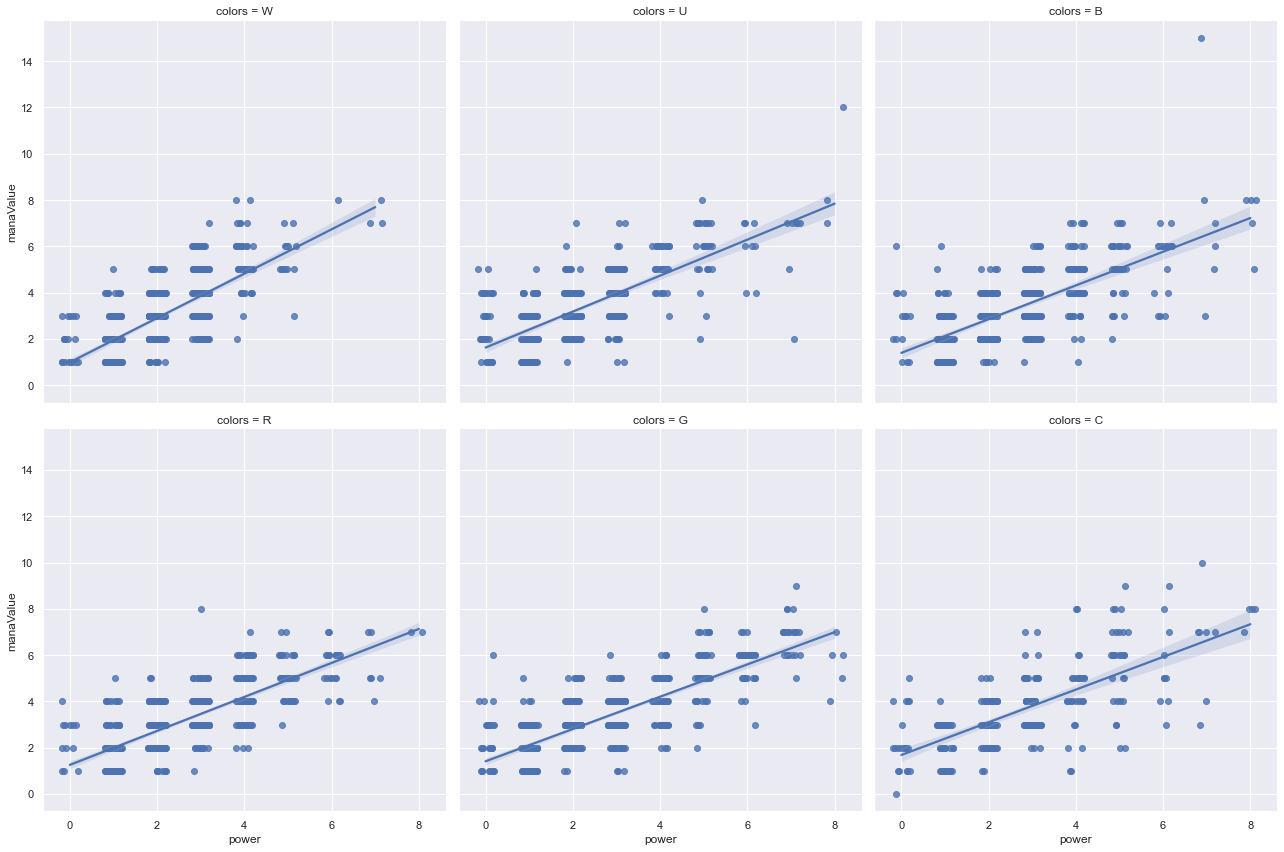

In [89]:
g = sns.FacetGrid(creatures.query('power < 9'), col='colors', col_wrap=3, height = 6)
g.map(sns.regplot, 'power', 'manaValue', x_jitter=.2)
